In [12]:
# Import modules
import datetime
import numpy as np
import pandas as pd
import spiceypy

# get the kernels
spiceypy.furnsh("kernels/lsk/naif0012.tls")
spiceypy.furnsh("kernels/spk/de432s.bsp")

# Set the initial time and end time
initial_time = datetime.datetime(2021, 10, 1).strftime("%Y-%m-%dT%H:%M:%S")
end_time = datetime.datetime(2022, 6, 1).strftime("%Y-%m-%dT%H:%M:%S")

# Convert the time to ephemeris time for spiceypy
initial_time_et = spiceypy.utc2et(initial_time)
end_time_et = spiceypy.utc2et(end_time)

# Create a time interval
delta_hours_in_seconds = 3600.0
time_interval = np.arange(initial_time_et, end_time_et, delta_hours_in_seconds)

In [13]:
# create an empty dataframe
inner_solar_system_df = pd.DataFrame()
# column for all ETs
inner_solar_system_df.loc[:,"et"] = time_interval
# convert ETs to UTC
inner_solar_system_df.loc[:,"utc"] = inner_solar_system_df['et'].apply(lambda x: spiceypy.et2datetime(et=x))

# to calculate the phase angle between the sun and venus as seen from earth
# the phaseq takes in the target, illumination source, observer, and abberation correction which is not that important in this case
# target and observer are switched up, in this case the earth is the target and venus is the observer
# because you can only get the phase angle from in this case the sun to venus, which isnt the same as the angle would be if the earth was the observer
inner_solar_system_df.loc[:,"earth_venus2sun_angle"] = inner_solar_system_df['et'].apply(lambda x: np.degrees(spiceypy.phaseq(et=x, target='399', illmn = '10', obsrvr='299', abcorr='LT+S')))

# to calculate the phase angle between the moon and the sun as seen from earth
inner_solar_system_df.loc[:,"earth_moon2sun_angle"] = inner_solar_system_df['et'].apply(lambda x: np.degrees(spiceypy.phaseq(et=x, target='399', illmn = '10', obsrvr='301', abcorr='LT+S')))

# to calculate the phase angle between the moon and venus as seen from earth
inner_solar_system_df.loc[:,"earth_moon2venus_angle"] = inner_solar_system_df['et'].apply(lambda x: np.degrees(spiceypy.phaseq(et=x, target='399', illmn = '299', obsrvr='301', abcorr='LT+S')))

# set the photogenic column to 1 if the phase angles are within the desired range, if not set it to 0
inner_solar_system_df.loc[:,"photogenic"] = inner_solar_system_df.apply(lambda x: 1 if (x['earth_venus2sun_angle'] > 30.0) & (x['earth_moon2sun_angle'] > 30.0) & (x['earth_moon2venus_angle'] < 30.0) else 0, axis=1)

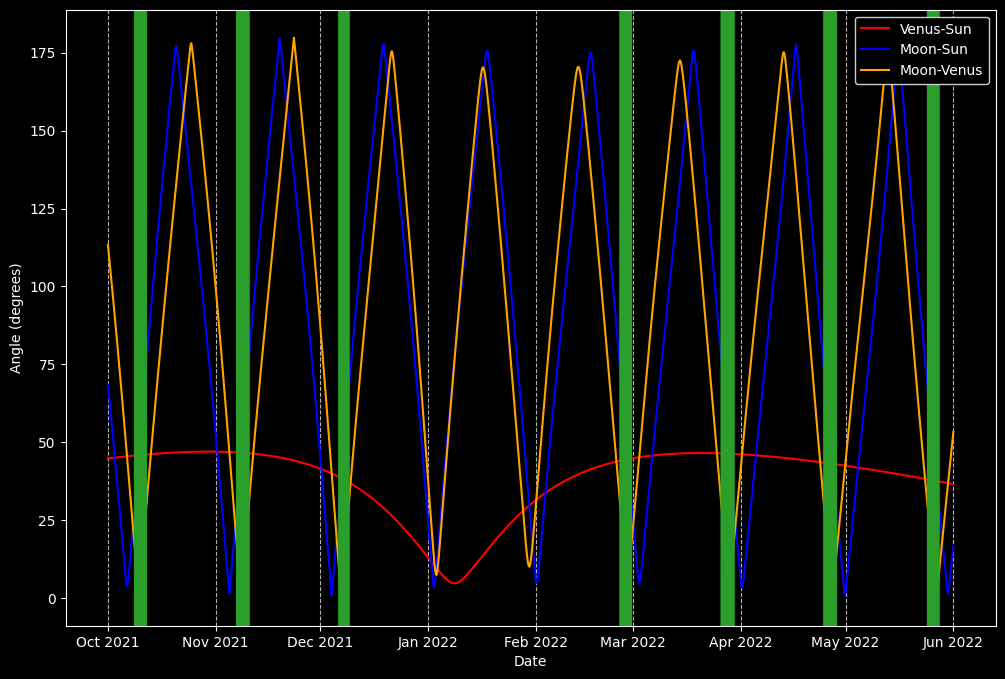

In [16]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

# we are vampires no light allowed
plt.style.use('dark_background')

# create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# create the subplots for each of the angles
ax.plot(inner_solar_system_df['utc'], inner_solar_system_df['earth_venus2sun_angle'], label="Venus-Sun", color='red')
ax.plot(inner_solar_system_df['utc'], inner_solar_system_df['earth_moon2sun_angle'], label="Moon-Sun", color='blue')
ax.plot(inner_solar_system_df['utc'], inner_solar_system_df['earth_moon2venus_angle'], label="Moon-Venus", color='orange')

# set the labels and the grid
ax.set_xlabel("Date")
ax.set_ylabel("Angle (degrees)")
ax.grid(axis="x", linestyle="dashed", alpha=0.7)

# add readable month and year to the x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# add a vertical line for the photogenic moments
for photogenic in inner_solar_system_df.loc[inner_solar_system_df['photogenic'] == 1]['utc']:
    ax.axvline(photogenic, color='tab:green', alpha=0.5)


ax.legend(fancybox=True, loc="upper right", framealpha=1)